# ?

In [145]:
import kaggle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import chi2_contingency, shapiro

from statsmodels.stats.proportion import proportions_ztest
from zipfile import ZipFile

In [146]:
# Credit Fusion, Will Cukierski. (2011). Give Me Some Credit. Kaggle. https://kaggle.com/competitions/GiveMeSomeCredit
os.system('kaggle competitions download -c GiveMeSomeCredit')

0

In [147]:
# Open zip file downloaded from kaggle api.
with ZipFile('./GiveMeSomeCredit.zip', 'r') as z:
    z.extractall('.')

In [148]:
# Get all descriptions.
df_dict = pd.read_excel("Data Dictionary.xls", sheet_name='Sheet1', header=1)
with pd.option_context('display.max_colwidth', None):
    display(df_dict)

,Variable Name,Description,Type
0,SeriousDlqin2yrs,Person experienced 90 days past due delinquency or worse,Y/N
1,RevolvingUtilizationOfUnsecuredLines,Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits,percentage
2,age,Age of borrower in years,integer
3,NumberOfTime30-59DaysPastDueNotWorse,Number of times borrower has been 30-59 days past due but no worse in the last 2 years.,integer
4,DebtRatio,"Monthly debt payments, alimony,living costs divided by monthy gross income",percentage
5,MonthlyIncome,Monthly income,real
6,NumberOfOpenCreditLinesAndLoans,Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards),integer
7,NumberOfTimes90DaysLate,Number of times borrower has been 90 days or more past due.,integer
8,NumberRealEstateLoansOrLines,Number of mortgage and real estate loans including home equity lines of credit,integer
9,NumberOfTime60-89DaysPastDueNotWorse,Number of times borrower has been 60-89 days past due but no worse in the last 2 years.,integer


In [149]:
# Extract training data.
df_raw = pd.read_csv('cs-training.csv', header=0, index_col=0)
df_raw.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [150]:
X = df_raw.drop(columns='SeriousDlqin2yrs')
y = df_raw[['SeriousDlqin2yrs']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((120000, 10), (30000, 10), (120000, 1), (30000, 1))

In [151]:
# Create a dataframe to store all metrics.
df_metric = pd.DataFrame(columns=['model', 'auc'])
df_metric

,model,auc


## Attempt 1: baseline

The simplest solution would be to apply the simplest classification model: logistic regression.

In [152]:
# For fast experiment, let's drop all NaN values.
df_train = X_train.copy()
df_train['SeriousDlqin2yrs'] = y_train
df_train_baseline = df_train.dropna(how='any')
X_train_baseline = df_train_baseline.drop(columns='SeriousDlqin2yrs')
y_train_baseline = df_train_baseline['SeriousDlqin2yrs']

df_test = X_test.copy()
df_test['SeriousDlqin2yrs'] = y_test
df_test_baseline = df_test.dropna(how='any')
X_test_baseline = df_test_baseline.drop(columns='SeriousDlqin2yrs')
y_test_baseline = df_test_baseline['SeriousDlqin2yrs']

X_train_baseline.shape, X_test_baseline.shape, y_train_baseline.shape, y_test_baseline.shape

((96194, 10), (24075, 10), (96194,), (24075,))

In [153]:
# Baseline: logistic regression.
baseline_log = LogisticRegression(random_state=52).fit(X_train_baseline, y_train_baseline)

auc_baseline = roc_auc_score(y_test_baseline, baseline_log.predict_proba(X_test_baseline)[:, 1])
df_metric.loc['baseline_log'] = ['logistic_regression', auc_baseline]

df_metric

c:\Users\Kenji\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,auc
baseline_log,logistic_regression,0.649776


In [154]:
# Baseline: decision tree
baseline_tree = DecisionTreeClassifier(random_state=52).fit(X_train_baseline, y_train_baseline)

auc_baseline = roc_auc_score(y_test_baseline, baseline_tree.predict_proba(X_test_baseline)[:, 1])
df_metric.loc['baseline_tree'] = ['decision_tree', auc_baseline]

df_metric

,model,auc
baseline_log,logistic_regression,0.649776
baseline_tree,decision_tree,0.607758


## Multi variable analysis

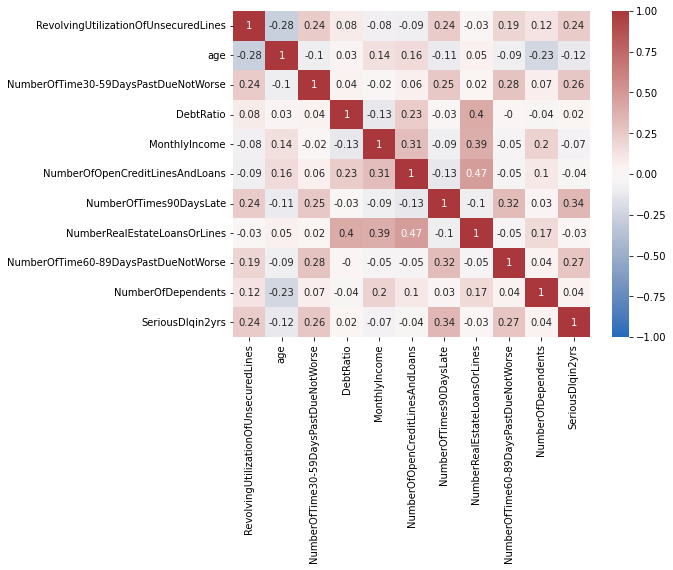

In [155]:
plt.figure(figsize=(8, 6))
fig = sns.heatmap(df_train.corr(method='spearman').round(2), vmin=-1, vmax=1, cmap='vlag', annot=True)
plt.show()

In [156]:
# Past defaults variables can be analysed together.
# Of all past defaults, which are the gravest?

df_train['gravest_default'] = np.select(
    [ 
        (df_train['NumberOfTimes90DaysLate'] == 0) & (df_train['NumberOfTime60-89DaysPastDueNotWorse'] == 0) & (df_train['NumberOfTime30-59DaysPastDueNotWorse'] == 0),
        df_train['NumberOfTimes90DaysLate'] > 0,
        (df_train['NumberOfTimes90DaysLate'] == 0) & (df_train['NumberOfTime60-89DaysPastDueNotWorse'] > 0),
        (df_train['NumberOfTimes90DaysLate'] == 0) & (df_train['NumberOfTime60-89DaysPastDueNotWorse'] == 0) & (df_train['NumberOfTime30-59DaysPastDueNotWorse'] > 0),
    ],
    [
        'no_default', 'def>90', 'def60~89', 'def<30'
    ], '?'
)

df_train[['gravest_default']].value_counts(dropna=False)

gravest_default
no_default         95674
def<30             13841
def>90              6642
def60~89            3843
Name: count, dtype: int64

In [157]:
display(df_train.groupby(['gravest_default'], as_index=False).agg({'SeriousDlqin2yrs':['count', 'mean']}))
print('It makes sense, loan applicants with past records of graver cases on non-payment are associated with higher default probability.')

gravest_default SeriousDlqin2yrs          
                             count      mean
0        def60~89             3843  0.250846
1          def<30            13841  0.119717
2          def>90             6642  0.418097
3      no_default            95674  0.027416

It makes sense, loan applicants with past records of graver cases on non-payment are associated with higher default probability.


In [158]:
# Hypothesis test.
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n * min(confusion_matrix.shape) - 1))


no_default = df_train.loc[df_train['gravest_default'] == 'no_default', 'SeriousDlqin2yrs'].sum()
no_all = df_train.loc[df_train['gravest_default'] == 'no_default'].shape[0]

def1 = df_train.loc[df_train['gravest_default'] == 'def<30', 'SeriousDlqin2yrs'].sum()
def1_all = df_train.loc[df_train['gravest_default'] == 'def<30'].shape[0]

def2 = df_train.loc[df_train['gravest_default'] == 'def60~89', 'SeriousDlqin2yrs'].sum()
def2_all = df_train.loc[df_train['gravest_default'] == 'def60~89'].shape[0]

def3 = df_train.loc[df_train['gravest_default'] == 'def>90', 'SeriousDlqin2yrs'].sum()
def3_all = df_train.loc[df_train['gravest_default'] == 'def>90'].shape[0]

confusion_matrix = np.array([[no_default, def1, def2, def3],
                             [no_all, def1_all, def2_all, def3_all]])

cv = cramers_v(confusion_matrix)
print(f"Cramér's V:{cv}")
print('For 1 degree of freedom, any value between 0.1 to 0.3 is considered a moderate correlation.')
print('There appears to be a moderate positive correlation between current default probability and previous degrees of default.')

Cramér's V:0.2243238268562583
For 1 degree of freedom, any value between 0.1 to 0.3 is considered a moderate correlation.
There appears to be a moderate positive correlation between current default probability and previous degrees of default.


In [159]:
def feat_eng_grave_default(df):

    df['gravest_default'] = np.select(
        [ 
            (df['NumberOfTimes90DaysLate'] == 0) & (df['NumberOfTime60-89DaysPastDueNotWorse'] == 0) & (df['NumberOfTime30-59DaysPastDueNotWorse'] == 0),
            df['NumberOfTimes90DaysLate'] > 0,
            (df['NumberOfTimes90DaysLate'] == 0) & (df['NumberOfTime60-89DaysPastDueNotWorse'] > 0),
            (df['NumberOfTimes90DaysLate'] == 0) & (df['NumberOfTime60-89DaysPastDueNotWorse'] == 0) & (df['NumberOfTime30-59DaysPastDueNotWorse'] > 0),
        ],
        [
            'no_default', 'def>90', 'def60~89', 'def<30'
        ], '?'
    )

    df_default = pd.get_dummies(data=df[['gravest_default']],  prefix='gravest_default', dtype='int')
    df_default = df_default.drop(columns=['gravest_default_no_default'])

    df = pd.concat([df, df_default], axis=1)
    df = df.drop(columns='gravest_default')

    return df

feat_eng_grave_default(df_train)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs,gravest_default_def60~89,gravest_default_def<30,gravest_default_def>90
97955,0.251886,28,1,0.284626,2100.0,3,0,0,0,0.0,1,0,1,0
148649,0.262441,39,0,0.286171,10000.0,12,0,1,0,1.0,0,0,0,0
134055,0.000000,38,0,0.000000,4000.0,4,0,0,0,0.0,0,0,0,0
117878,0.199019,31,0,0.583222,750.0,5,0,0,0,0.0,0,0,0,0
56766,0.066822,45,0,0.296185,10300.0,6,0,1,0,2.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97296,0.842368,26,2,0.043304,1500.0,3,0,0,1,0.0,1,1,0,0
567,0.732711,29,0,0.338531,8400.0,10,0,1,0,0.0,0,0,0,0
137882,0.022424,66,0,102.000000,NaN,7,0,0,0,0.0,0,0,0,0
32249,0.143767,37,0,890.000000,NaN,3,0,1,0,0.0,0,0,0,0


## Single variable analysis

Analysing each variable in order to improve our model.

In [160]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 120000 entries, 97955 to 96350
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  120000 non-null  float64
 1   age                                   120000 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse  120000 non-null  int64  
 3   DebtRatio                             120000 non-null  float64
 4   MonthlyIncome                         96194 non-null   float64
 5   NumberOfOpenCreditLinesAndLoans       120000 non-null  int64  
 6   NumberOfTimes90DaysLate               120000 non-null  int64  
 7   NumberRealEstateLoansOrLines          120000 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse  120000 non-null  int64  
 9   NumberOfDependents                    116834 non-null  float64
 10  SeriousDlqin2yrs                      120000 non-null  int64  
 11  gr

#### Target

SeriousDlqin2yrs
0    0.933158
1    0.066842
Name: proportion, dtype: float64

<AxesSubplot:title={'center':'Default proportion'}, xlabel='SeriousDlqin2yrs'>

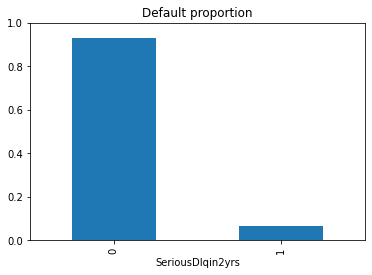

In [161]:
# SeriusDlqin2yrs (target): "Person experienced 90 days past due delinquency or worse"
display(y_train['SeriousDlqin2yrs'].value_counts(dropna=False, normalize=True))
y_train['SeriousDlqin2yrs'].value_counts(dropna=False, normalize=True).plot(kind='bar', ylim=(0, 1), title='Default proportion')

#### RevolvingUtilizationOfUnsecuredLines

In [162]:
#RevolvingUtilizationOfUnsecuredLines: percentual usage of credit.
X_train['RevolvingUtilizationOfUnsecuredLines'].describe(percentiles = np.arange(0, 100, 10) / 100).to_frame().T.round(3)

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
RevolvingUtilizationOfUnsecuredLines,120000.0,6.197,261.506,0.0,0.0,0.003,0.019,0.043,0.083,0.154,0.271,0.444,0.698,0.98,50708.0


In [163]:
# Since practically 90% of the dataset have features < 1, should we truncate it?

# How is the behaviour when feature > 1?
above1 = df_train.loc[df_train['RevolvingUtilizationOfUnsecuredLines'] > 1, 'SeriousDlqin2yrs'].mean()
until1 = df_train.loc[df_train['RevolvingUtilizationOfUnsecuredLines'] <= 1, 'SeriousDlqin2yrs'].mean()
print(f"Default:\n- above1: {above1}\n- until1: {until1}")

display(X_train['RevolvingUtilizationOfUnsecuredLines'].describe(percentiles = np.arange(990, 1000, 1) / 1000).to_frame().T.round(3))
print('Observing the percentiles (99% ~ 100%) it is clear the tail is not linear. Therefore, a non linear correlation method will be applied.')

display(df_train.loc[df_train['RevolvingUtilizationOfUnsecuredLines'] > 1][['SeriousDlqin2yrs',
                                                                            'RevolvingUtilizationOfUnsecuredLines']].corr(method='spearman'))
print('The weak correlation of the upper tail indicates no harm in truncating feature > 1 to 1.')

# Creating a new column.
df_train['RevolvingUtilizationOfUnsecuredLines_trunc'] = np.where(df_train['RevolvingUtilizationOfUnsecuredLines'] > 1, 1, df_train['RevolvingUtilizationOfUnsecuredLines'])
df_train['RevolvingUtilizationOfUnsecuredLines_trunc'].describe()

Default:
- above1: 0.3797515995483628
- until1: 0.0597564405205253


,count,mean,std,min,50%,99%,99.1%,99.2%,99.3%,99.4%,99.5%,99.6%,99.7%,99.8%,99.9%,max
RevolvingUtilizationOfUnsecuredLines,120000.0,6.197,261.506,0.0,0.154,1.093,1.115,1.143,1.191,1.259,1.352,1.471,1.715,2.63,1577.033,50708.0


Observing the percentiles (99% ~ 100%) it is clear the tail is not linear. Therefore, a non linear correlation method will be applied.


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines
SeriousDlqin2yrs,1.000000,0.014338
RevolvingUtilizationOfUnsecuredLines,0.014338,1.000000


The weak correlation of the upper tail indicates no harm in truncating feature > 1 to 1.


count    120000.000000
mean          0.318765
std           0.349182
min           0.000000
25%           0.029728
50%           0.154034
75%           0.558114
max           1.000000
Name: RevolvingUtilizationOfUnsecuredLines_trunc, dtype: float64

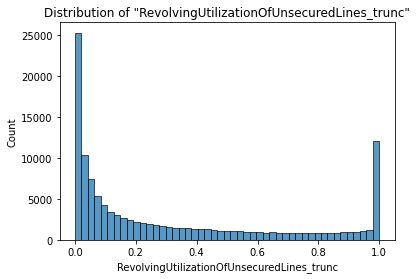

In [164]:
fig = sns.histplot(df_train['RevolvingUtilizationOfUnsecuredLines_trunc'])
fig.set(title='Distribution of "RevolvingUtilizationOfUnsecuredLines_trunc"')
plt.show()

In [165]:
# Correlation.
display(df_train[['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines_trunc']].corr(method='spearman'))
print('Weak correlation, but strong effect considering the unbalanced data.')

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines_trunc
SeriousDlqin2yrs,1.000000,0.240984
RevolvingUtilizationOfUnsecuredLines_trunc,0.240984,1.000000


Weak correlation, but strong effect considering the unbalanced data.


In [166]:
# Creating categories for quantiles.
df_train['RevolvingUtilizationOfUnsecuredLines_trunc_perc'] = pd.qcut(df_train['RevolvingUtilizationOfUnsecuredLines_trunc'],
                                                                      q=4,
                                                                      labels=['Q1', 'Q2', 'Q3', 'Q4'])

display(df_train.groupby(['RevolvingUtilizationOfUnsecuredLines_trunc_perc'], as_index=False).agg({'SeriousDlqin2yrs':['mean', 'median']}))
print('Q4 is a relevant condition to increase the default chance.')

RevolvingUtilizationOfUnsecuredLines_trunc_perc SeriousDlqin2yrs       
                                                              mean median
0                                              Q1         0.018700    0.0
1                                              Q2         0.019567    0.0
2                                              Q3         0.049800    0.0
3                                              Q4         0.179300    0.0

Q4 is a relevant condition to increase the default chance.


In [167]:
# How relevant are feature vs target?
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n * min(confusion_matrix.shape) - 1))

q1_default = df_train.loc[df_train['RevolvingUtilizationOfUnsecuredLines_trunc_perc'] == 'Q1', 'SeriousDlqin2yrs'].sum()
q1_all = df_train.loc[df_train['RevolvingUtilizationOfUnsecuredLines_trunc_perc'] == 'Q1'].shape[0]

q2_default = df_train.loc[df_train['RevolvingUtilizationOfUnsecuredLines_trunc_perc'] == 'Q2', 'SeriousDlqin2yrs'].sum()
q2_all = df_train.loc[df_train['RevolvingUtilizationOfUnsecuredLines_trunc_perc'] == 'Q2'].shape[0]

q3_default = df_train.loc[df_train['RevolvingUtilizationOfUnsecuredLines_trunc_perc'] == 'Q3', 'SeriousDlqin2yrs'].sum()
q3_all = df_train.loc[df_train['RevolvingUtilizationOfUnsecuredLines_trunc_perc'] == 'Q3'].shape[0]

q4_default = df_train.loc[df_train['RevolvingUtilizationOfUnsecuredLines_trunc_perc'] == 'Q4', 'SeriousDlqin2yrs'].sum()
q4_all = df_train.loc[df_train['RevolvingUtilizationOfUnsecuredLines_trunc_perc'] == 'Q4'].shape[0]

confusion_matrix = np.array([[q1_default, q2_default, q3_default, q4_default],
                             [q1_all, q2_all, q3_all, q4_all]])

cv = cramers_v(confusion_matrix)
print(f"Cramér's V:{cv}")
print('For 1 degree of freedom, any value between 0.1 to 0.3 is considered a moderate correlation.')
print('There appears to be a moderate negative correlation between default and usage of unsecured credit.')

Cramér's V:0.1646632184862712
For 1 degree of freedom, any value between 0.1 to 0.3 is considered a moderate correlation.
There appears to be a moderate negative correlation between default and usage of unsecured credit.


In [168]:
# What are the feature delimitors in train dataset?
df_train.groupby(['RevolvingUtilizationOfUnsecuredLines_trunc_perc']).agg({'RevolvingUtilizationOfUnsecuredLines_trunc':['min', 'max']})

RevolvingUtilizationOfUnsecuredLines_trunc  \
                                                                                       min   
RevolvingUtilizationOfUnsecuredLines_trunc_perc                                              
Q1                                                                                0.000000   
Q2                                                                                0.029728   
Q3                                                                                0.154042   
Q4                                                                                0.558118   

                                                           
                                                      max  
RevolvingUtilizationOfUnsecuredLines_trunc_perc            
Q1                                               0.029728  
Q2                                               0.154026  
Q3                                               0.558113  
Q4                                               1.000000

In [169]:
def feat_eng_non_secure_credit_usage(df):
    # Truncate to 1.
    df['RevolvingUtilizationOfUnsecuredLines_trunc'] = np.where(df['RevolvingUtilizationOfUnsecuredLines'] > 1, 1, df['RevolvingUtilizationOfUnsecuredLines'])
    
    # Create category based on train data.
    df['RevolvingUtilizationOfUnsecuredLines_trunc_perc'] = np.select(
        [
            df['RevolvingUtilizationOfUnsecuredLines_trunc'].between(0, 0.029728),
            df['RevolvingUtilizationOfUnsecuredLines_trunc'].between(0.029728, 0.154026),
            df['RevolvingUtilizationOfUnsecuredLines_trunc'].between(0.154027, 0.558113),
            df['RevolvingUtilizationOfUnsecuredLines_trunc'].between(0.558114, 1),
        ], ['Q1', 'Q2', 'Q3', 'Q4'], 'error'
    )
    try:
        assert 'error' not in df['RevolvingUtilizationOfUnsecuredLines_trunc_perc']
    except Exception as e:
        print(f"Error on credit usage feature engineering: {e}") 
    
    # Dummify.
    df_nonsecure_credit = pd.get_dummies(data=df[['RevolvingUtilizationOfUnsecuredLines_trunc_perc']], prefix='nonsecure_credit_usage', dtype='int')
    df_nonsecure_credit = df_nonsecure_credit.drop(columns='nonsecure_credit_usage_Q3')

    df = pd.concat([df, df_nonsecure_credit], axis=1)
    df = df.drop(columns='RevolvingUtilizationOfUnsecuredLines_trunc_perc')
    return df

feat_eng_non_secure_credit_usage(df_train)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs,gravest_default,RevolvingUtilizationOfUnsecuredLines_trunc,nonsecure_credit_usage_Q1,nonsecure_credit_usage_Q2,nonsecure_credit_usage_Q4
97955,0.251886,28,1,0.284626,2100.0,3,0,0,0,0.0,1,def<30,0.251886,0,0,0
148649,0.262441,39,0,0.286171,10000.0,12,0,1,0,1.0,0,no_default,0.262441,0,0,0
134055,0.000000,38,0,0.000000,4000.0,4,0,0,0,0.0,0,no_default,0.000000,1,0,0
117878,0.199019,31,0,0.583222,750.0,5,0,0,0,0.0,0,no_default,0.199019,0,0,0
56766,0.066822,45,0,0.296185,10300.0,6,0,1,0,2.0,0,no_default,0.066822,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97296,0.842368,26,2,0.043304,1500.0,3,0,0,1,0.0,1,def60~89,0.842368,0,0,1
567,0.732711,29,0,0.338531,8400.0,10,0,1,0,0.0,0,no_default,0.732711,0,0,1
137882,0.022424,66,0,102.000000,NaN,7,0,0,0,0.0,0,no_default,0.022424,1,0,0
32249,0.143767,37,0,890.000000,NaN,3,0,1,0,0.0,0,no_default,0.143767,0,1,0


#### Age

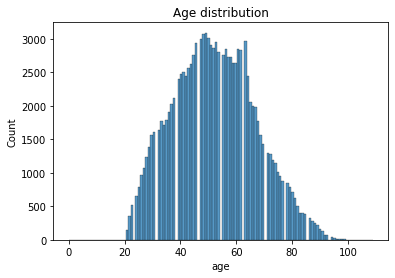

It appears to be normal distribuited. Is it really?


In [170]:
# Age: age of loan solicitor.
fig = sns.histplot(df_train['age'])
fig.set(title='Age distribution')
plt.show()
print('It appears to be normal distribuited. Is it really?')

In [171]:
# Hypothesis test for normal distribution
st, p = shapiro(df_train['age'])
if p < 0.05:
    print('Reject H0, therefore, statiscally speaking, age follows a normal distribution.')
else:
    print('Non reject H0, therefore, statistically speaking, age do not follow a normal distribution.')

Reject H0, therefore, statiscally speaking, age follows a normal distribution.


c:\Users\Kenji\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [172]:
# Parametric correlation.
display(df_train[['age', 'SeriousDlqin2yrs']].corr(method='pearson'))
print('Negative Weak correlation')

,age,SeriousDlqin2yrs
age,1.000000,-0.114219
SeriousDlqin2yrs,-0.114219,1.000000


Negative Weak correlation


In [173]:
# Inconsistencies?
display(df_train['age'].describe(percentiles = np.arange(0, 100, 10) / 100).to_frame().T.round(3))
print('While ask for a lona with 0 years old is, 109 is possible.')

df_train = df_train.loc[df_train['age'] > 0]
display(df_train['age'].describe(percentiles = np.arange(0, 100, 10) / 100).to_frame().T.round(3))

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
age,120000.0,52.282,14.783,0.0,0.0,33.0,39.0,44.0,48.0,52.0,56.0,60.0,65.0,72.0,109.0


While ask for a lona with 0 years old is, 109 is possible.


,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
age,119999.0,52.283,14.782,21.0,21.0,33.0,39.0,44.0,48.0,52.0,56.0,60.0,65.0,72.0,109.0


In [174]:
# Are specific ranges more propenses for default?
df_train['age_decade'] = np.select(
    [
        df_train['age'] <= 29,
        df_train['age'].between(30, 39),
        df_train['age'].between(40, 49),
        df_train['age'].between(50, 59),
        df_train['age'].between(60, 69),
        df_train['age'] >= 70
    ],
    [
        '20s', '30s', '40s', '50s', '60s', '>70s'
    ], '?'
)

df_train.groupby(['age_decade'], as_index=False).agg({'SeriousDlqin2yrs':['count', 'mean']}).round(2)


age_decade SeriousDlqin2yrs      
                        count  mean
0        20s             7126  0.12
1        30s            18528  0.10
2        40s            27469  0.08
3        50s            28271  0.06
4        60s            23110  0.04
5       >70s            15495  0.02

In [175]:
df_train

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs,gravest_default,RevolvingUtilizationOfUnsecuredLines_trunc,RevolvingUtilizationOfUnsecuredLines_trunc_perc,age_decade
97955,0.251886,28,1,0.284626,2100.0,3,0,0,0,0.0,1,def<30,0.251886,Q3,20s
148649,0.262441,39,0,0.286171,10000.0,12,0,1,0,1.0,0,no_default,0.262441,Q3,30s
134055,0.000000,38,0,0.000000,4000.0,4,0,0,0,0.0,0,no_default,0.000000,Q1,30s
117878,0.199019,31,0,0.583222,750.0,5,0,0,0,0.0,0,no_default,0.199019,Q3,30s
56766,0.066822,45,0,0.296185,10300.0,6,0,1,0,2.0,0,no_default,0.066822,Q2,40s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97296,0.842368,26,2,0.043304,1500.0,3,0,0,1,0.0,1,def60~89,0.842368,Q4,20s
567,0.732711,29,0,0.338531,8400.0,10,0,1,0,0.0,0,no_default,0.732711,Q4,20s
137882,0.022424,66,0,102.000000,NaN,7,0,0,0,0.0,0,no_default,0.022424,Q1,60s
32249,0.143767,37,0,890.000000,NaN,3,0,1,0,0.0,0,no_default,0.143767,Q2,30s


In [176]:
def feat_eng_age(df):
    # Removing 0 years.
    df = df.loc[df['age'] > 0]
    
    # Dummify.
    df['age_decade'] = np.select(
        [
            df['age'] <= 29,
            df['age'].between(30, 39),
            df['age'].between(40, 49),
            df['age'].between(50, 59),
            df['age'].between(60, 69),
            df['age'] >= 70
        ],
        [
            '20s', '30s', '40s', '50s', '60s', '>70s'
        ], '?'
    )
    # Dummify.
    df_age = pd.get_dummies(data=df[['age_decade']], prefix='age_decade', dtype='int')
    df_age = df_age.drop(columns='age_decade_50s')

    df = pd.concat([df, df_age], axis=1)
    df = df.drop(columns='age_decade')
    return df

feat_eng_age(df_train)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs,gravest_default,RevolvingUtilizationOfUnsecuredLines_trunc,RevolvingUtilizationOfUnsecuredLines_trunc_perc,age_decade_20s,age_decade_30s,age_decade_40s,age_decade_60s,age_decade_>70s
97955,0.251886,28,1,0.284626,2100.0,3,0,0,0,0.0,1,def<30,0.251886,Q3,1,0,0,0,0
148649,0.262441,39,0,0.286171,10000.0,12,0,1,0,1.0,0,no_default,0.262441,Q3,0,1,0,0,0
134055,0.000000,38,0,0.000000,4000.0,4,0,0,0,0.0,0,no_default,0.000000,Q1,0,1,0,0,0
117878,0.199019,31,0,0.583222,750.0,5,0,0,0,0.0,0,no_default,0.199019,Q3,0,1,0,0,0
56766,0.066822,45,0,0.296185,10300.0,6,0,1,0,2.0,0,no_default,0.066822,Q2,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97296,0.842368,26,2,0.043304,1500.0,3,0,0,1,0.0,1,def60~89,0.842368,Q4,1,0,0,0,0
567,0.732711,29,0,0.338531,8400.0,10,0,1,0,0.0,0,no_default,0.732711,Q4,1,0,0,0,0
137882,0.022424,66,0,102.000000,NaN,7,0,0,0,0.0,0,no_default,0.022424,Q1,0,0,0,1,0
32249,0.143767,37,0,890.000000,NaN,3,0,1,0,0.0,0,no_default,0.143767,Q2,0,1,0,0,0


In [177]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119999 entries, 97955 to 96350
Data columns (total 15 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines             119999 non-null  float64
 1   age                                              119999 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse             119999 non-null  int64  
 3   DebtRatio                                        119999 non-null  float64
 4   MonthlyIncome                                    96193 non-null   float64
 5   NumberOfOpenCreditLinesAndLoans                  119999 non-null  int64  
 6   NumberOfTimes90DaysLate                          119999 non-null  int64  
 7   NumberRealEstateLoansOrLines                     119999 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse             119999 non-null  int64  
 9   NumberOfDependent

#### NumberOfTime30-59DaysPastDueNotWorse

In [178]:
#NumberOfTime30-59DaysPastDueNotWorse: number of minor events of default in the past 2 years.

display(df_train.groupby(['NumberOfTime30-59DaysPastDueNotWorse'], as_index=False).agg({'SeriousDlqin2yrs':['count', 'mean']}).round(2))
print('Considering the default% is over 6%, it is possible to consider to attribute a higher probability of default when feature > 0')

df_train['NumberOfTime30-59DaysPastDueNotWorse_dummy'] = np.where(df_train['NumberOfTime30-59DaysPastDueNotWorse'] == 0, 0, 1)
display(df_train.groupby(['NumberOfTime30-59DaysPastDueNotWorse_dummy'], as_index=False).agg({'SeriousDlqin2yrs':['count', 'mean']}).round(2))

NumberOfTime30-59DaysPastDueNotWorse SeriousDlqin2yrs      
                                                   count  mean
0                                     0           100740  0.04
1                                     1            12840  0.15
2                                     2             3691  0.26
3                                     3             1442  0.35
4                                     4              607  0.42
5                                     5              280  0.45
6                                     6              108  0.51
7                                     7               47  0.55
8                                     8               19  0.32
9                                     9               10  0.30
10                                   10                3  0.67
11                                   12                2  0.50
12                                   13                1  1.00
13                                   96                5  0.80
14                                   98              204  0.52

Considering the default% is over 6%, it is possible to consider to attribute a higher probability of default when feature > 0


NumberOfTime30-59DaysPastDueNotWorse_dummy SeriousDlqin2yrs      
                                                        count  mean
0                                          0           100740  0.04
1                                          1            19259  0.21

In [179]:
def feat_eng_past_default_2m(df):
    df['NumberOfTime30-59DaysPastDueNotWorse_dummy'] = np.where(df['NumberOfTime30-59DaysPastDueNotWorse'] == 0, 0, 1)

    return df

feat_eng_past_default_2m(df_train)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs,gravest_default,RevolvingUtilizationOfUnsecuredLines_trunc,RevolvingUtilizationOfUnsecuredLines_trunc_perc,age_decade,NumberOfTime30-59DaysPastDueNotWorse_dummy
97955,0.251886,28,1,0.284626,2100.0,3,0,0,0,0.0,1,def<30,0.251886,Q3,20s,1
148649,0.262441,39,0,0.286171,10000.0,12,0,1,0,1.0,0,no_default,0.262441,Q3,30s,0
134055,0.000000,38,0,0.000000,4000.0,4,0,0,0,0.0,0,no_default,0.000000,Q1,30s,0
117878,0.199019,31,0,0.583222,750.0,5,0,0,0,0.0,0,no_default,0.199019,Q3,30s,0
56766,0.066822,45,0,0.296185,10300.0,6,0,1,0,2.0,0,no_default,0.066822,Q2,40s,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97296,0.842368,26,2,0.043304,1500.0,3,0,0,1,0.0,1,def60~89,0.842368,Q4,20s,1
567,0.732711,29,0,0.338531,8400.0,10,0,1,0,0.0,0,no_default,0.732711,Q4,20s,0
137882,0.022424,66,0,102.000000,NaN,7,0,0,0,0.0,0,no_default,0.022424,Q1,60s,0
32249,0.143767,37,0,890.000000,NaN,3,0,1,0,0.0,0,no_default,0.143767,Q2,30s,0


#### MonthlyIncome

In [180]:
# Monthly income.
df_train['MonthlyIncome'].describe().round(1)

# How many missing values we have?
null_income = df_train.loc[df_train['MonthlyIncome'].isnull()].shape[0]
print(f"High percentage of missing values: {null_income / df_train.shape[0]}")

High percentage of missing values: 0.1983849865415545


In [181]:
# Moral hazard: are income omission cases more prone to default?
df_train['income_omission'] = np.where(df_train['MonthlyIncome'].notnull(), 0, 1)

display(df_train.groupby(['income_omission'], as_index=False).agg({'SeriousDlqin2yrs':['count', 'mean']}).round(2))

default_cases = np.array([df_train.loc[df_train['income_omission'] == 0, 'SeriousDlqin2yrs'].sum(),
                          df_train.loc[df_train['income_omission'] == 1, 'SeriousDlqin2yrs'].sum()])
non_default_cases = np.array([df_train.loc[df_train['income_omission'] == 0].shape[0],
                              df_train.loc[df_train['income_omission'] == 0].shape[0]])

st, p = proportions_ztest(default_cases, non_default_cases)
if p < 0.05:
    print('Reject H0, therefore, statistically speaking there is no difference.')
else:
    print('No reject H0, therefore, the differences are relevant.')

print('Hypothesis denied: there are no evidences of moral hazard by income omission.')

print('What to do with cases of missing values?')

income_omission SeriousDlqin2yrs      
                             count  mean
0               0            96193  0.07
1               1            23806  0.06

Reject H0, therefore, statistically speaking there is no difference.
Hypothesis denied: there are no evidences of moral hazard by income omission.
What to do with cases of missing values?


In [182]:
# Are different income groups more/less likely to default?
display(df_train['MonthlyIncome'].describe(percentiles = np.arange(0, 100, 10) / 100).to_frame().T.round(3))

# Since we do not know where this data was extract from, we will use a quantile separation.
df_train['MonthlyIncome_quant'] = pd.qcut(df_train['MonthlyIncome'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
display(df_train.groupby(['MonthlyIncome_quant'], as_index=False).agg({'SeriousDlqin2yrs':['count', 'mean']}))
print('The feature appears to have a negative correlation with target.')

print("Similar to theorical and empirical evidence, the income does not appears to be normal distributed, therefore, a non-parametric correlation will be calculated.")
display(df_train[['SeriousDlqin2yrs', 'MonthlyIncome']].corr(method='spearman'))

,count,mean,std,min,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
MonthlyIncome,96193.0,6687.814,15161.816,0.0,0.0,2029.0,3000.0,3800.0,4550.8,5400.0,6308.4,7500.0,9083.0,11666.0,3008750.0


MonthlyIncome_quant SeriousDlqin2yrs          
                                 count      mean
0                  Q1            24230  0.092530
1                  Q2            24001  0.078455
2                  Q3            23922  0.060279
3                  Q4            24040  0.045965

The feature appears to have a negative correlation with target.
Similar to theorical and empirical evidence, the income does not appears to be normal distributed, therefore, a non-parametric correlation will be calculated.


,SeriousDlqin2yrs,MonthlyIncome
SeriousDlqin2yrs,1.000000,-0.067794
MonthlyIncome,-0.067794,1.000000


In [183]:
# As missing values displays a similar default rate as Q3, all missing values will be considered Q3.
df_train.loc[df_train['MonthlyIncome'].isnull(), 'MonthlyIncome_quant'] = 'Q3'
display(df_train.groupby(['MonthlyIncome_quant'], as_index=False).agg({'SeriousDlqin2yrs':['count', 'mean'], 'MonthlyIncome':['min', 'max']}))

# Median income for Q3.
df_train.loc[df_train['MonthlyIncome_quant'] == 'Q3', 'MonthlyIncome'].median()

MonthlyIncome_quant SeriousDlqin2yrs           MonthlyIncome           
                                 count      mean           min        max
0                  Q1            24230  0.092530           0.0     3400.0
1                  Q2            24001  0.078455        3401.0     5400.0
2                  Q3            47728  0.058477        5401.0     8249.0
3                  Q4            24040  0.045965        8250.0  3008750.0

6609.0

In [184]:
def feat_eng_income(df):

    # Identifying income omission.
    df['income_omission'] = np.where(df['MonthlyIncome'].notnull(), 0, 1)

    # Fill missing values with Q3 median.
    df.loc[df['MonthlyIncome'].isnull(), 'MonthlyIncome'] = 6609

    # Feature engineering for Income variable.
    df['MonthlyIncome_quant'] = np.select(
        [
            df['MonthlyIncome'] <= 3400,
            df['MonthlyIncome'].between(3401, 5400),
            df['MonthlyIncome'].between(5401, 8249),
            df['MonthlyIncome'] >= 8250
        ], ['Q1', 'Q2', 'Q3', 'Q4'], 'error'
    )
    try:
        assert 'error' not in df['MonthlyIncome_quant']
    except Exception as e:
        print(f"Error on income's feature engineering: {e}") 
    
    df_income = pd.get_dummies(data=df[['MonthlyIncome_quant']], prefix='income', dtype='int')
    df_income = df_income.drop(columns='income_Q3')

    df = pd.concat([df, df_income], axis=1)
    df = df.drop(columns='MonthlyIncome_quant')
    return df

feat_eng_income(df_train)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs,gravest_default,RevolvingUtilizationOfUnsecuredLines_trunc,RevolvingUtilizationOfUnsecuredLines_trunc_perc,age_decade,NumberOfTime30-59DaysPastDueNotWorse_dummy,income_omission,income_Q1,income_Q2,income_Q4
97955,0.251886,28,1,0.284626,2100.0,3,0,0,0,0.0,1,def<30,0.251886,Q3,20s,1,0,1,0,0
148649,0.262441,39,0,0.286171,10000.0,12,0,1,0,1.0,0,no_default,0.262441,Q3,30s,0,0,0,0,1
134055,0.000000,38,0,0.000000,4000.0,4,0,0,0,0.0,0,no_default,0.000000,Q1,30s,0,0,0,1,0
117878,0.199019,31,0,0.583222,750.0,5,0,0,0,0.0,0,no_default,0.199019,Q3,30s,0,0,1,0,0
56766,0.066822,45,0,0.296185,10300.0,6,0,1,0,2.0,0,no_default,0.066822,Q2,40s,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97296,0.842368,26,2,0.043304,1500.0,3,0,0,1,0.0,1,def60~89,0.842368,Q4,20s,1,0,1,0,0
567,0.732711,29,0,0.338531,8400.0,10,0,1,0,0.0,0,no_default,0.732711,Q4,20s,0,0,0,0,1
137882,0.022424,66,0,102.000000,6609.0,7,0,0,0,0.0,0,no_default,0.022424,Q1,60s,0,1,0,0,0
32249,0.143767,37,0,890.000000,6609.0,3,0,1,0,0.0,0,no_default,0.143767,Q2,30s,0,1,0,0,0


In [185]:
q1_default = df_train.loc[df_train['MonthlyIncome_quant'] == 'Q1', 'SeriousDlqin2yrs'].sum()
q1_all = df_train.loc[df_train['MonthlyIncome_quant'] == 'Q1'].shape[0]

q2_default = df_train.loc[df_train['MonthlyIncome_quant'] == 'Q2', 'SeriousDlqin2yrs'].sum()
q2_all = df_train.loc[df_train['MonthlyIncome_quant'] == 'Q2'].shape[0]

q3_default = df_train.loc[df_train['MonthlyIncome_quant'] == 'Q3', 'SeriousDlqin2yrs'].sum()
q3_all = df_train.loc[df_train['MonthlyIncome_quant'] == 'Q3'].shape[0]

q4_default = df_train.loc[df_train['MonthlyIncome_quant'] == 'Q4', 'SeriousDlqin2yrs'].sum()
q4_all = df_train.loc[df_train['MonthlyIncome_quant'] == 'Q4'].shape[0]

confusion_matrix = np.array([[q1_default, q2_default, q3_default, q4_default],
                             [q1_all, q2_all, q3_all, q4_all]])

cv = cramers_v(confusion_matrix)
print(f"Cramér's V:{cv}")
print('For 1 degree of freedom, any value below 0.1 is considered as weak correlation.')
print('Although there appears to be a negative correlation between default and income, the effect seems weak.')

Cramér's V:0.042428223612413614
For 1 degree of freedom, any value below 0.1 is considered as weak correlation.
Although there appears to be a negative correlation between default and income, the effect seems weak.


### NumberOfTimes90DaysLate

In [186]:
# NumberOfTimes90DaysLate: number of times borrower has been 90 days or more past due.
display(df_train['NumberOfTimes90DaysLate'].describe(percentiles = np.arange(10, 100, 10) / 100).to_frame().T.round(3))
print('Almost every loan applicant do not have previous defaults. Analysing the top 10%:')
display(df_train['NumberOfTimes90DaysLate'].describe(percentiles = np.arange(90, 100, 1) / 100).to_frame().T.round(3))

df_train.sort_values('NumberOfTimes90DaysLate', ascending=True)['NumberOfTimes90DaysLate'].value_counts(sort=False)

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
NumberOfTimes90DaysLate,119999.0,0.26,4.109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.0


Almost every loan applicant do not have previous defaults. Analysing the top 10%:


,count,mean,std,min,50%,90%,91%,92%,93%,94%,95%,96%,97%,98%,99%,max
NumberOfTimes90DaysLate,119999.0,0.26,4.109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,98.0


NumberOfTimes90DaysLate
0     113357
1       4188
2       1265
3        517
4        218
5        100
6         63
7         34
8         14
9         14
10         6
11         4
12         2
13         4
14         2
15         1
17         1
96         5
98       204
Name: count, dtype: int64

In [187]:
# Should the feature be truncated at 1?
display(df_train.groupby(['NumberOfTimes90DaysLate'], as_index=False).agg({'SeriousDlqin2yrs':['count', 'mean']}).round(2))
print('The default rate increases substantially. It appears is possible to separate the sample in 3 groups:')
print('a. feature == 0\nb. feature == 1\nc. feature > 1')

df_train['number_past_default'] = np.select(
    [
        df_train['NumberOfTimes90DaysLate'] == 0,
        df_train['NumberOfTimes90DaysLate'] == 1,
        df_train['NumberOfTimes90DaysLate'] > 0,
    ], ['never', 'once', 'more_than_once'], '?'
)
display(df_train.groupby(['number_past_default'], as_index=False).agg({'SeriousDlqin2yrs':['count', 'mean']}).round(2))

NumberOfTimes90DaysLate SeriousDlqin2yrs      
                                      count  mean
0                        0           113357  0.05
1                        1             4188  0.34
2                        2             1265  0.51
3                        3              517  0.60
4                        4              218  0.63
5                        5              100  0.62
6                        6               63  0.65
7                        7               34  0.82
8                        8               14  0.71
9                        9               14  0.64
10                      10                6  0.67
11                      11                4  0.75
12                      12                2  0.50
13                      13                4  0.50
14                      14                2  0.50
15                      15                1  0.00
16                      17                1  1.00
17                      96                5  0.80
18                      98              204  0.52

The default rate increases substantially. It appears is possible to separate the sample in 3 groups:
a. feature == 0
b. feature == 1
c. feature > 1


number_past_default SeriousDlqin2yrs      
                                 count  mean
0      more_than_once             2454  0.55
1               never           113357  0.05
2                once             4188  0.34

In [188]:
# Checking correlation significance.
never_default = df_train.loc[df_train['number_past_default'] == 'never', 'SeriousDlqin2yrs'].sum()
never_all = df_train.loc[df_train['number_past_default'] == 'never'].shape[0]

once_default = df_train.loc[df_train['number_past_default'] == 'once', 'SeriousDlqin2yrs'].sum()
once_all = df_train.loc[df_train['number_past_default'] == 'once'].shape[0]

mto_default = df_train.loc[df_train['number_past_default'] == 'more_than_once', 'SeriousDlqin2yrs'].sum()
mto_all = df_train.loc[df_train['number_past_default'] == 'more_than_once'].shape[0]


confusion_matrix = np.array([[never_default, once_default, mto_default],
                             [never_all, once_all, mto_all]])

cv = cramers_v(confusion_matrix)
print(f"Cramér's V:{cv}")
print('For 1 degree of freedom, any value between 0.1 to 0.3 is considered a moderate correlation.')
print('There appears to be a moderate negative correlation between default and past defaults.')

Cramér's V:0.19512309368088443
For 1 degree of freedom, any value between 0.1 to 0.3 is considered a moderate correlation.
There appears to be a moderate negative correlation between default and past defaults.


In [189]:
def feat_eng_past_default_more4m(df):

    # Truncate the number of past defaults.
    df['number_past_default'] = np.select(
        [
            df['NumberOfTimes90DaysLate'] == 0,
            df['NumberOfTimes90DaysLate'] == 1,
            df['NumberOfTimes90DaysLate'] > 0,
        ], ['never', 'once', 'more_than_once'], '?'
    )

    # Dummify.
    df_default = pd.get_dummies(data=df[['number_past_default']], prefix='number_past_default', dtype='int') 
    df_default = df_default.drop(columns='number_past_default_never')

    df = pd.concat([df, df_default], axis=1)
    df = df.drop(columns='number_past_default')
    return df

feat_eng_past_default_more4m(df_train)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs,gravest_default,RevolvingUtilizationOfUnsecuredLines_trunc,RevolvingUtilizationOfUnsecuredLines_trunc_perc,age_decade,NumberOfTime30-59DaysPastDueNotWorse_dummy,income_omission,MonthlyIncome_quant,number_past_default_more_than_once,number_past_default_once
97955,0.251886,28,1,0.284626,2100.0,3,0,0,0,0.0,1,def<30,0.251886,Q3,20s,1,0,Q1,0,0
148649,0.262441,39,0,0.286171,10000.0,12,0,1,0,1.0,0,no_default,0.262441,Q3,30s,0,0,Q4,0,0
134055,0.000000,38,0,0.000000,4000.0,4,0,0,0,0.0,0,no_default,0.000000,Q1,30s,0,0,Q2,0,0
117878,0.199019,31,0,0.583222,750.0,5,0,0,0,0.0,0,no_default,0.199019,Q3,30s,0,0,Q1,0,0
56766,0.066822,45,0,0.296185,10300.0,6,0,1,0,2.0,0,no_default,0.066822,Q2,40s,0,0,Q4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97296,0.842368,26,2,0.043304,1500.0,3,0,0,1,0.0,1,def60~89,0.842368,Q4,20s,1,0,Q1,0,0
567,0.732711,29,0,0.338531,8400.0,10,0,1,0,0.0,0,no_default,0.732711,Q4,20s,0,0,Q4,0,0
137882,0.022424,66,0,102.000000,6609.0,7,0,0,0,0.0,0,no_default,0.022424,Q1,60s,0,1,Q3,0,0
32249,0.143767,37,0,890.000000,6609.0,3,0,1,0,0.0,0,no_default,0.143767,Q2,30s,0,1,Q3,0,0


### NumberOfDependents

In [190]:
# Feature statistics.
display(df_train['NumberOfDependents'].describe())

count    116833.000000
mean          0.758245
std           1.115499
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          20.000000
Name: NumberOfDependents, dtype: float64

In [191]:
# What is the target behaviour of rows with the missing feature?
display(df_train.groupby(['NumberOfDependents'], as_index=False, dropna=False).agg({'SeriousDlqin2yrs':['count', 'mean']}).round(3))
print('Applicants without information about NumberOfDependentes have a low default probability.')

med_dep = df_train['NumberOfDependents'].median()
print(f'Median: {med_dep}')

df_train['NumberOfDependents'] = df_train['NumberOfDependents'].fillna(med_dep)
display(df_train.groupby(['NumberOfDependents'], as_index=False, dropna=False).agg({'SeriousDlqin2yrs':['count', 'mean']}).round(3))
print('Applicants without information about NumberOfDependentes have a low default probability.')


NumberOfDependents SeriousDlqin2yrs       
                                 count   mean
0                 0.0            69436  0.059
1                 1.0            21081  0.072
2                 2.0            15640  0.081
3                 3.0             7585  0.091
4                 4.0             2303  0.098
5                 5.0              593  0.089
6                 6.0              125  0.160
7                 7.0               43  0.116
8                 8.0               18  0.000
9                 9.0                3  0.000
10               10.0                4  0.000
11               13.0                1  0.000
12               20.0                1  0.000
13                NaN             3166  0.045

Applicants without information about NumberOfDependentes have a low default probability.
Median: 0.0


NumberOfDependents SeriousDlqin2yrs       
                                 count   mean
0                 0.0            72602  0.058
1                 1.0            21081  0.072
2                 2.0            15640  0.081
3                 3.0             7585  0.091
4                 4.0             2303  0.098
5                 5.0              593  0.089
6                 6.0              125  0.160
7                 7.0               43  0.116
8                 8.0               18  0.000
9                 9.0                3  0.000
10               10.0                4  0.000
11               13.0                1  0.000
12               20.0                1  0.000

Applicants without information about NumberOfDependentes have a low default probability.


In [192]:
def feat_eng_dependents(df):
    # Fill missing values with median.
    med_dep = df['NumberOfDependents'].median()
    df['NumberOfDependents'] = df['NumberOfDependents'].fillna(med_dep)
    return df

feat_eng_dependents(df_train)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs,gravest_default,RevolvingUtilizationOfUnsecuredLines_trunc,RevolvingUtilizationOfUnsecuredLines_trunc_perc,age_decade,NumberOfTime30-59DaysPastDueNotWorse_dummy,income_omission,MonthlyIncome_quant,number_past_default
97955,0.251886,28,1,0.284626,2100.0,3,0,0,0,0.0,1,def<30,0.251886,Q3,20s,1,0,Q1,never
148649,0.262441,39,0,0.286171,10000.0,12,0,1,0,1.0,0,no_default,0.262441,Q3,30s,0,0,Q4,never
134055,0.000000,38,0,0.000000,4000.0,4,0,0,0,0.0,0,no_default,0.000000,Q1,30s,0,0,Q2,never
117878,0.199019,31,0,0.583222,750.0,5,0,0,0,0.0,0,no_default,0.199019,Q3,30s,0,0,Q1,never
56766,0.066822,45,0,0.296185,10300.0,6,0,1,0,2.0,0,no_default,0.066822,Q2,40s,0,0,Q4,never
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97296,0.842368,26,2,0.043304,1500.0,3,0,0,1,0.0,1,def60~89,0.842368,Q4,20s,1,0,Q1,never
567,0.732711,29,0,0.338531,8400.0,10,0,1,0,0.0,0,no_default,0.732711,Q4,20s,0,0,Q4,never
137882,0.022424,66,0,102.000000,6609.0,7,0,0,0,0.0,0,no_default,0.022424,Q1,60s,0,1,Q3,never
32249,0.143767,37,0,890.000000,6609.0,3,0,1,0,0.0,0,no_default,0.143767,Q2,30s,0,1,Q3,never


### What we learned so far?

- Tolerance: non payment are classified as default only after 90 days.
- Unbalanced: in average, less than 1 out of 10 loads ends in default.
- `RevolvingUtilizationOfUnsecuredLines`: sample have an upper tail with gigantic numbers. After analysis, it was possible to truncate it to 1. Higher degrees of features indicates high probability of default, and vice-and-versa.
- `age`: normal distributed (verified statistically) with weak negative correlation with target. 
- `NumberOfTime30-59DaysPastDueNotWorse`: extremely unbalanced sample, with lots of 0. When feature > 1, default% increased.
- `MonthlyIncome`: a lot of missing values. There are no evidences of missing values being more/less prone to default. Weak negative correlation with target.
- `NumberOfTimes90DaysLate`: extremely unbalanced with lots of 0. After categorization in 3 groups, the feature presented a moderate positive correlation with target.
- `gravest_default`: the graver past default records, the more likely current loans are to end up in default. Moderade positive correlation with target.

## Feature Engineering

In [193]:
# Apply all feature engineering developed 
df_train2 = df_train.copy(deep=True)
df_test2 = df_test.copy(deep=True)

df_train2 = feat_eng_non_secure_credit_usage(df_train2)
df_train2 = feat_eng_age(df_train2)
df_train2 = feat_eng_income(df_train2)
df_train2 = feat_eng_past_default_2m(df_train2)
df_train2 = feat_eng_past_default_more4m(df_train2)
df_train2 = feat_eng_grave_default(df_train2)
df_train2 = feat_eng_dependents(df_train2)

df_test2 = feat_eng_non_secure_credit_usage(df_test2)
df_test2 = feat_eng_age(df_test2)
df_test2 = feat_eng_income(df_test2)
df_test2 = feat_eng_past_default_2m(df_test2)
df_test2 = feat_eng_past_default_more4m(df_test2)
df_test2 = feat_eng_grave_default(df_test2)
df_test2 = feat_eng_dependents(df_test2)

In [194]:
# Removing all NaN.
print(f'before: {df_train2.shape}, {df_test2.shape}')

df_train2 = df_train2.dropna(how='any') 
df_test2 = df_test2.dropna(how='any') 

print(f'after: {df_train2.shape}, {df_test2.shape}')

before: (119999, 30), (30000, 30)
after: (119999, 30), (30000, 30)


In [195]:
# Organizing the dataset.
X_train2 = df_train2.drop(columns='SeriousDlqin2yrs')
y_train2 = df_train2[['SeriousDlqin2yrs']]

X_test2 = df_test2.drop(columns='SeriousDlqin2yrs')
y_test2 = df_test2[['SeriousDlqin2yrs']]

X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape 

((119999, 29), (119999, 1), (30000, 29), (30000, 1))

In [196]:
l1 = list(X_train2.columns)
l2 = list(X_test2.columns)

set(l1) - set(l2)

set()

## Attempt 2: better features

In [197]:
# Better features: logistic regression.
better_feat_log = LogisticRegression(random_state=52).fit(X_train2, y_train2)

auc_better_feat = roc_auc_score(y_test2, better_feat_log.predict_proba(X_test2)[:, 1])
df_metric.loc['better_feat_log'] = ['logistic_regression', auc_better_feat]

df_metric

c:\Users\Kenji\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Kenji\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Kenji\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passe

,model,auc
baseline_log,logistic_regression,0.649776
baseline_tree,decision_tree,0.607758
better_feat_log,logistic_regression,0.672348


In [198]:
# Better features: decision tree.
better_feat_tree = DecisionTreeClassifier(random_state=52).fit(X_train2, y_train2)

auc_better_feat = roc_auc_score(y_test2, better_feat_tree.predict_proba(X_test2)[:, 1])
df_metric.loc['better_feat_tree'] = ['decision_tree', auc_better_feat]

df_metric

c:\Users\Kenji\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


,model,auc
baseline_log,logistic_regression,0.649776
baseline_tree,decision_tree,0.607758
better_feat_log,logistic_regression,0.672348
better_feat_tree,decision_tree,0.597816


## Predict

In [199]:
best_model = better_feat_log
display(best_model)

LogisticRegression(random_state=52)

In [200]:
df_pred = pd.read_csv('cs-test.csv', index_col=0)
print(df_pred.shape)
df_pred.head()

(101503, 11)


,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,NaN,0.885519,43,0,0.177513,5700.0,4,0,0,0,0.0
2,NaN,0.463295,57,0,0.527237,9141.0,15,0,4,0,2.0
3,NaN,0.043275,59,0,0.687648,5083.0,12,0,1,0,2.0
4,NaN,0.280308,38,1,0.925961,3200.0,7,0,2,0,0.0
5,NaN,1.000000,27,0,0.019917,3865.0,4,0,0,0,1.0


In [201]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101503 entries, 1 to 101503
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      0 non-null       float64
 1   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 2   age                                   101503 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 4   DebtRatio                             101503 non-null  float64
 5   MonthlyIncome                         81400 non-null   float64
 6   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 7   NumberOfTimes90DaysLate               101503 non-null  int64  
 8   NumberRealEstateLoansOrLines          101503 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 10  NumberOfDependents                    98877 non-null   float64
dtypes: fl

In [202]:
df_pred = feat_eng_non_secure_credit_usage(df_pred)
df_pred = feat_eng_age(df_pred)
df_pred = feat_eng_income(df_pred)
df_pred = feat_eng_past_default_2m(df_pred)
df_pred = feat_eng_past_default_more4m(df_pred)
df_pred = feat_eng_grave_default(df_pred)
df_pred = feat_eng_dependents(df_pred)

In [203]:
# Final dataset used in model.
X = df_pred.drop(columns='SeriousDlqin2yrs')
display(X.shape)

list_feat = list(X.columns)
list_feat.sort()
display(list_feat)

X.info()

(101503, 29)

['DebtRatio',
 'MonthlyIncome',
 'NumberOfDependents',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTime30-59DaysPastDueNotWorse_dummy',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'RevolvingUtilizationOfUnsecuredLines',
 'RevolvingUtilizationOfUnsecuredLines_trunc',
 'age',
 'age_decade_20s',
 'age_decade_30s',
 'age_decade_40s',
 'age_decade_60s',
 'age_decade_>70s',
 'gravest_default_def60~89',
 'gravest_default_def<30',
 'gravest_default_def>90',
 'income_Q1',
 'income_Q2',
 'income_Q4',
 'income_omission',
 'nonsecure_credit_usage_Q1',
 'nonsecure_credit_usage_Q2',
 'nonsecure_credit_usage_Q4',
 'number_past_default_more_than_once',
 'number_past_default_once']

<class 'pandas.core.frame.DataFrame'>
Index: 101503 entries, 1 to 101503
Data columns (total 29 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines        101503 non-null  float64
 1   age                                         101503 non-null  int64  
 2   NumberOfTime30-59DaysPastDueNotWorse        101503 non-null  int64  
 3   DebtRatio                                   101503 non-null  float64
 4   MonthlyIncome                               101503 non-null  float64
 5   NumberOfOpenCreditLinesAndLoans             101503 non-null  int64  
 6   NumberOfTimes90DaysLate                     101503 non-null  int64  
 7   NumberRealEstateLoansOrLines                101503 non-null  int64  
 8   NumberOfTime60-89DaysPastDueNotWorse        101503 non-null  int64  
 9   NumberOfDependents                          101503 non-null  float64
 10  R

In [204]:
df_pred['pred'] = best_model.predict(X)
df_pred['pred_proba'] = best_model.predict_proba(X)[:, 1]

c:\Users\Kenji\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
c:\Users\Kenji\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [205]:
df_pred['pred'].value_counts(normalize=True)

pred
0    0.998108
1    0.001892
Name: proportion, dtype: float64

In [206]:
df_pred['pred_proba'].describe().round(3)

count    101503.000
mean          0.062
std           0.060
min           0.000
25%           0.022
50%           0.044
75%           0.083
max           0.884
Name: pred_proba, dtype: float64

## Export

In [207]:
# Save a csv file in submission specific format.
def format_float(value, num_characters):
    return "{:.{n}f}".format(value, n=num_characters)
    
df_submit = df_pred[['pred_proba']].copy(deep=True)
df_submit['pred_proba'] = df_submit['pred_proba'].apply(lambda x: format_float(x, 9))
df_submit.reset_index(inplace=True)
df_submit.columns = ['Id', 'Probability']
df_submit.to_csv('pred.csv', index=False)

In [208]:
# Save the artefact model.
with open('model1.pkl', 'wb') as file:
    pickle.dump(best_model, file)